In [5]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import pickle
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, GlobalAveragePooling2D, Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50, EfficientNetB0

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU available: {gpus}")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU detected. Training will use CPU.")

print(f"TensorFlow version: {tf.__version__}")

# Create directories
os.makedirs('models', exist_ok=True)
print("Setup complete")

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0
Setup complete


In [6]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print(f"Dataset path: {path}")

# Set data path
base_path = path
data_path = os.path.join(base_path, 'chest_xray')
print(f"Data path: {data_path}")

Dataset path: /kaggle/input/chest-xray-pneumonia
Data path: /kaggle/input/chest-xray-pneumonia/chest_xray


In [7]:
def count_images(directory):
    """Count images in each directory"""
    counts = {}
    for root, dirs, files in os.walk(directory):
        if 'NORMAL' in root or 'PNEUMONIA' in root:
            class_name = os.path.basename(root)
            split_name = os.path.basename(os.path.dirname(root))
            key = f"{split_name}/{class_name}"
            counts[key] = len([f for f in files if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
    return counts

# Count all images
image_counts = count_images(data_path)

# Display results
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
for key, count in sorted(image_counts.items()):
    print(f"{key:30s}: {count:5d} images")

# Calculate totals
train_normal = image_counts.get('train/NORMAL', 0)
train_pneumonia = image_counts.get('train/PNEUMONIA', 0)
val_normal = image_counts.get('val/NORMAL', 0)
val_pneumonia = image_counts.get('val/PNEUMONIA', 0)
test_normal = image_counts.get('test/NORMAL', 0)
test_pneumonia = image_counts.get('test/PNEUMONIA', 0)

print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
total_train = train_normal + train_pneumonia
print(f"Training: {total_train} images")
print(f"  Normal: {train_normal} ({train_normal/total_train*100:.2f}%)")
print(f"  Pneumonia: {train_pneumonia} ({train_pneumonia/total_train*100:.2f}%)")
print(f"  Imbalance Ratio: 1:{train_pneumonia/max(train_normal, 1):.2f}")

total_val = val_normal + val_pneumonia
print(f"\nValidation: {total_val} images (NOTE: Original val set is very small)")
print(f"Test: {test_normal + test_pneumonia} images")

DATASET STATISTICS
test/NORMAL                   :   234 images
test/PNEUMONIA                :   390 images
train/NORMAL                  :  1341 images
train/PNEUMONIA               :  3875 images
val/NORMAL                    :     8 images
val/PNEUMONIA                 :     8 images

CLASS DISTRIBUTION
Training: 5216 images
  Normal: 1341 (25.71%)
  Pneumonia: 3875 (74.29%)
  Imbalance Ratio: 1:2.89

Validation: 16 images (NOTE: Original val set is very small)
Test: 624 images


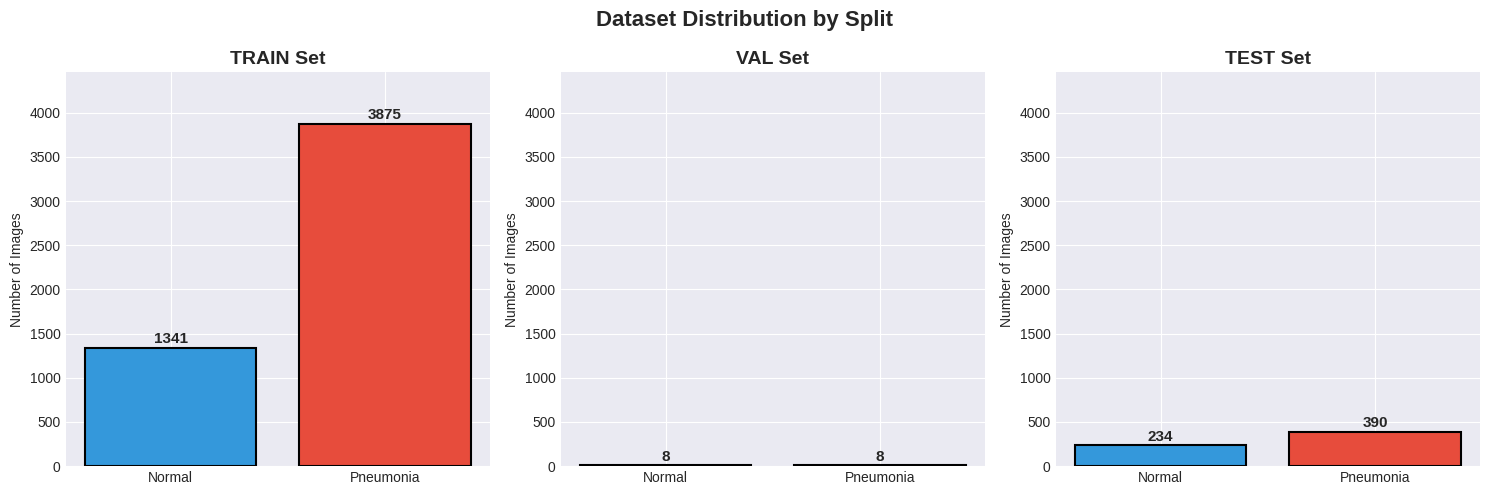

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

splits = ['train', 'val', 'test']
for idx, split in enumerate(splits):
    normal = image_counts.get(f'{split}/NORMAL', 0)
    pneumonia = image_counts.get(f'{split}/PNEUMONIA', 0)
    
    bars = axes[idx].bar(['Normal', 'Pneumonia'], [normal, pneumonia], 
                         color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'{split.upper()} Set', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].set_ylim(0, max(train_normal, train_pneumonia) * 1.15)
    
    for bar, v in zip(bars, [normal, pneumonia]):
        axes[idx].text(bar.get_x() + bar.get_width()/2, v + 50, str(v), 
                       ha='center', fontweight='bold', fontsize=11)

plt.suptitle('Dataset Distribution by Split', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

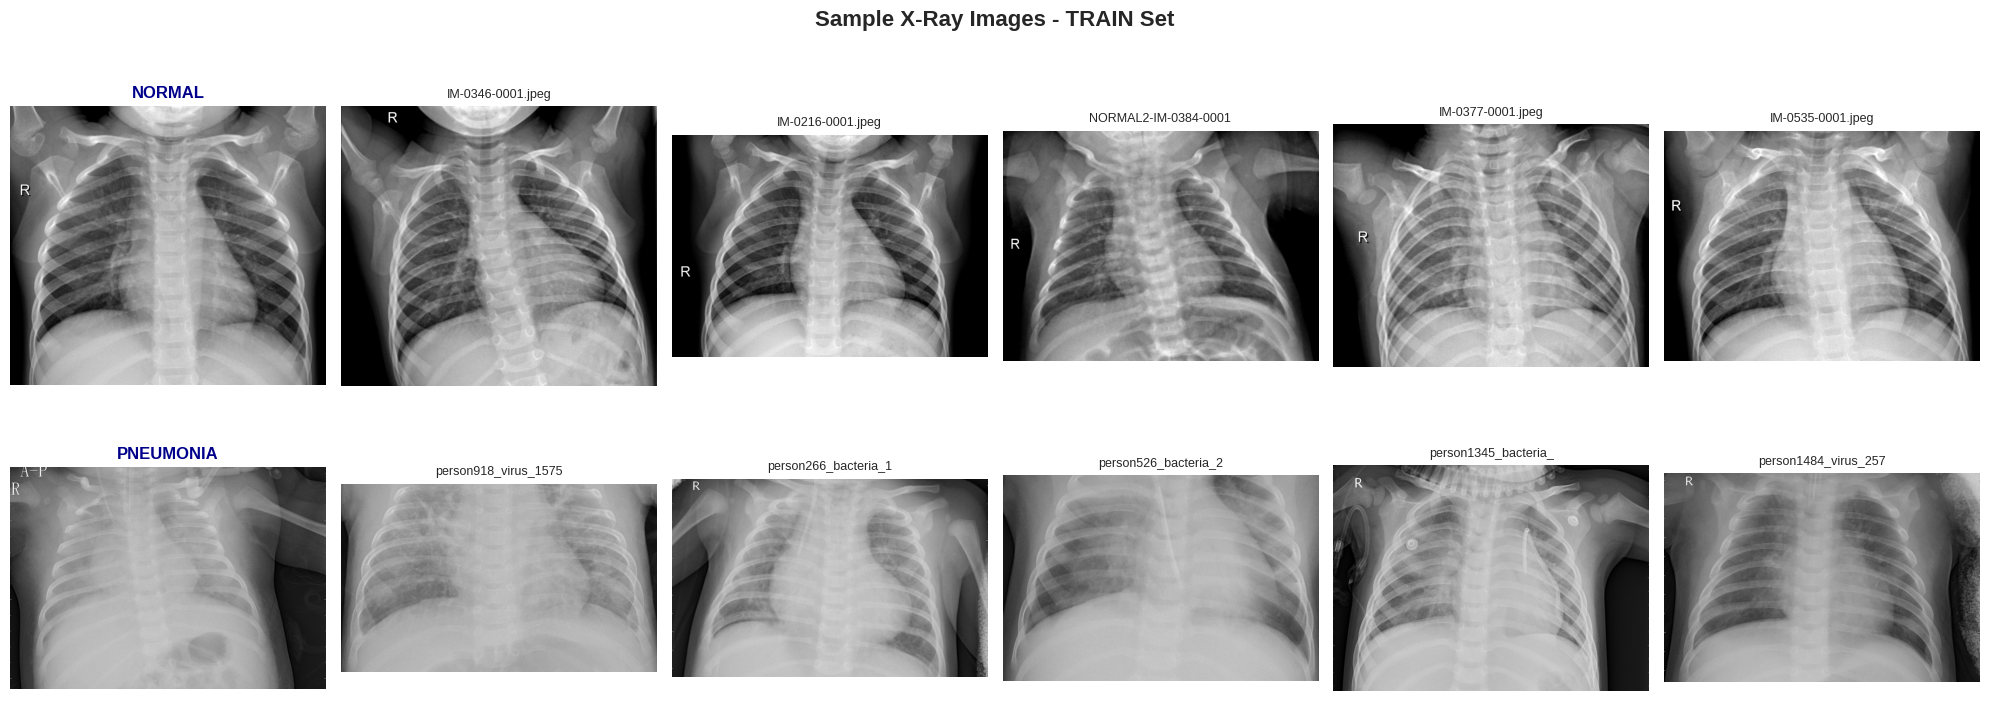

In [9]:
def display_sample_images(data_path, split='train', samples_per_class=6):
    """Display sample X-ray images from each class"""
    fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, split, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        
        selected = np.random.choice(image_files, 
                                    size=min(samples_per_class, len(image_files)), 
                                    replace=False)
        
        for img_idx, img_file in enumerate(selected):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            
            axes[class_idx, img_idx].imshow(img, cmap='gray')
            axes[class_idx, img_idx].axis('off')
            
            if img_idx == 0:
                axes[class_idx, img_idx].set_title(f'{class_name}', fontsize=12, 
                                                   fontweight='bold', color='darkblue')
            else:
                axes[class_idx, img_idx].set_title(img_file[:20], fontsize=9)
    
    plt.suptitle(f'Sample X-Ray Images - {split.upper()} Set', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

display_sample_images(data_path, split='train', samples_per_class=6)

In [10]:
def analyze_image_properties(data_path, split='train', num_samples=300):
    """Analyze dimensions, aspect ratios, and pixel statistics"""
    properties = {
        'widths': [], 'heights': [], 'aspect_ratios': [],
        'mean_intensities': [], 'std_intensities': [], 'classes': []
    }
    
    classes = ['NORMAL', 'PNEUMONIA']
    
    for class_name in classes:
        class_path = os.path.join(data_path, split, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
        sampled_files = np.random.choice(image_files, 
                                         size=min(num_samples, len(image_files)), 
                                         replace=False)
        
        for img_file in sampled_files:
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    h, w = img.shape
                    properties['widths'].append(w)
                    properties['heights'].append(h)
                    properties['aspect_ratios'].append(w / h)
                    properties['mean_intensities'].append(np.mean(img))
                    properties['std_intensities'].append(np.std(img))
                    properties['classes'].append(class_name)
            except Exception as e:
                continue  # Skip corrupted images
    
    return pd.DataFrame(properties)

df_properties = analyze_image_properties(data_path, split='train', num_samples=300)

print("=" * 60)
print("IMAGE PROPERTIES SUMMARY")
print("=" * 60)
print(f"Dimensions:")
print(f"  Width  - Min: {df_properties['widths'].min()}, Max: {df_properties['widths'].max()}, "
      f"Mean: {df_properties['widths'].mean():.1f}")
print(f"  Height - Min: {df_properties['heights'].min()}, Max: {df_properties['heights'].max()}, "
      f"Mean: {df_properties['heights'].mean():.1f}")
print(f"\nAspect Ratio: Min: {df_properties['aspect_ratios'].min():.3f}, "
      f"Max: {df_properties['aspect_ratios'].max():.3f}")
print(f"Pixel Intensity: Mean: {df_properties['mean_intensities'].mean():.2f} "
      f"+/- {df_properties['mean_intensities'].std():.2f}")

IMAGE PROPERTIES SUMMARY
Dimensions:
  Width  - Min: 428, Max: 2572, Mean: 1426.0
  Height - Min: 189, Max: 2476, Mean: 1093.7

Aspect Ratio: Min: 0.905, Max: 2.593
Pixel Intensity: Mean: 123.34 +/- 16.09


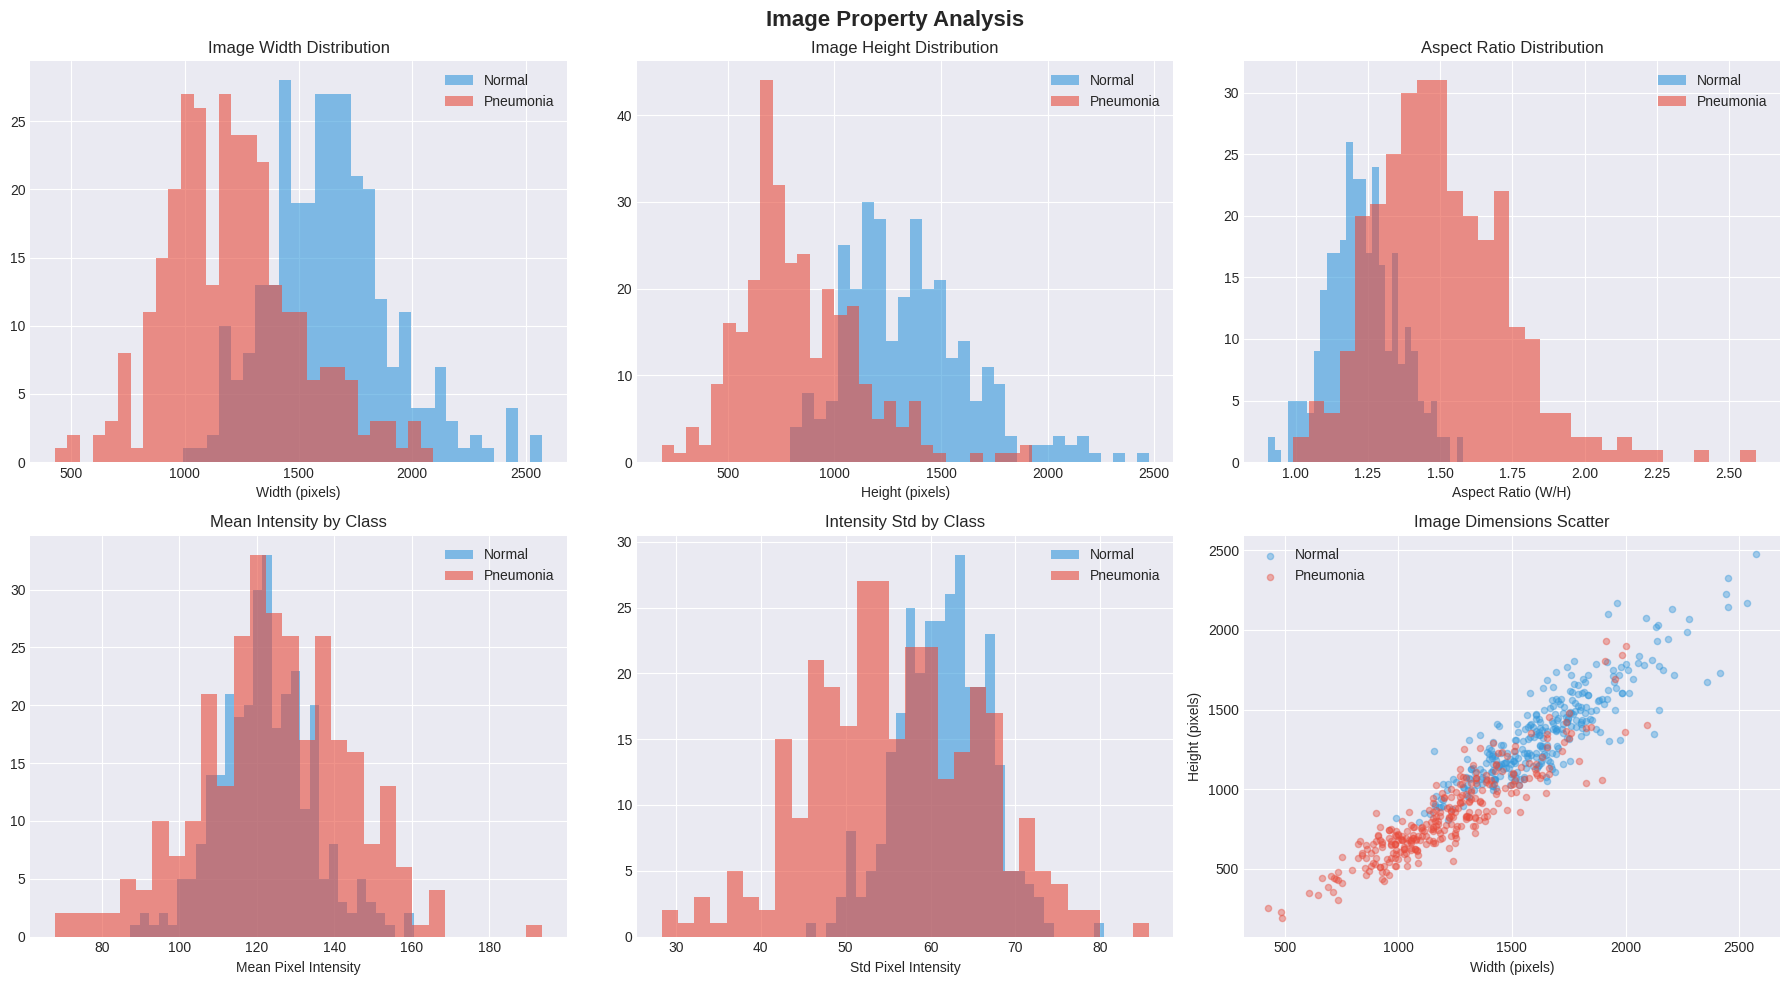

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

normal_data = df_properties[df_properties['classes'] == 'NORMAL']
pneumonia_data = df_properties[df_properties['classes'] == 'PNEUMONIA']

# Width distribution
axes[0, 0].hist(normal_data['widths'], alpha=0.6, label='Normal', bins=30, color='#3498db')
axes[0, 0].hist(pneumonia_data['widths'], alpha=0.6, label='Pneumonia', bins=30, color='#e74c3c')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_title('Image Width Distribution')
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(normal_data['heights'], alpha=0.6, label='Normal', bins=30, color='#3498db')
axes[0, 1].hist(pneumonia_data['heights'], alpha=0.6, label='Pneumonia', bins=30, color='#e74c3c')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_title('Image Height Distribution')
axes[0, 1].legend()

# Aspect ratio
axes[0, 2].hist(normal_data['aspect_ratios'], alpha=0.6, label='Normal', bins=30, color='#3498db')
axes[0, 2].hist(pneumonia_data['aspect_ratios'], alpha=0.6, label='Pneumonia', bins=30, color='#e74c3c')
axes[0, 2].set_xlabel('Aspect Ratio (W/H)')
axes[0, 2].set_title('Aspect Ratio Distribution')
axes[0, 2].legend()

# Mean intensity
axes[1, 0].hist(normal_data['mean_intensities'], alpha=0.6, label='Normal', bins=30, color='#3498db')
axes[1, 0].hist(pneumonia_data['mean_intensities'], alpha=0.6, label='Pneumonia', bins=30, color='#e74c3c')
axes[1, 0].set_xlabel('Mean Pixel Intensity')
axes[1, 0].set_title('Mean Intensity by Class')
axes[1, 0].legend()

# Std intensity
axes[1, 1].hist(normal_data['std_intensities'], alpha=0.6, label='Normal', bins=30, color='#3498db')
axes[1, 1].hist(pneumonia_data['std_intensities'], alpha=0.6, label='Pneumonia', bins=30, color='#e74c3c')
axes[1, 1].set_xlabel('Std Pixel Intensity')
axes[1, 1].set_title('Intensity Std by Class')
axes[1, 1].legend()

# Dimensions scatter
axes[1, 2].scatter(normal_data['widths'], normal_data['heights'],
                   alpha=0.4, label='Normal', s=20, color='#3498db')
axes[1, 2].scatter(pneumonia_data['widths'], pneumonia_data['heights'],
                   alpha=0.4, label='Pneumonia', s=20, color='#e74c3c')
axes[1, 2].set_xlabel('Width (pixels)')
axes[1, 2].set_ylabel('Height (pixels)')
axes[1, 2].set_title('Image Dimensions Scatter')
axes[1, 2].legend()

plt.suptitle('Image Property Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
def collect_all_images(data_path):
    """Collect all images and labels from train/val/test directories"""
    all_images = []
    all_labels = []
    
    splits = ['train', 'val', 'test']
    classes = ['NORMAL', 'PNEUMONIA']
    
    for split in splits:
        for class_name in classes:
            class_path = os.path.join(data_path, split, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
                
                for img_file in image_files:
                    img_path = os.path.join(class_path, img_file)
                    all_images.append(img_path)
                    all_labels.append(0 if class_name == 'NORMAL' else 1)
    
    return all_images, all_labels

# Collect all images
all_image_paths, all_labels = collect_all_images(data_path)

print("=" * 60)
print("COMBINED DATASET")
print("=" * 60)
print(f"Total images: {len(all_image_paths)}")
print(f"  Normal: {all_labels.count(0)}")
print(f"  Pneumonia: {all_labels.count(1)}")
print(f"  Imbalance Ratio: 1:{all_labels.count(1)/max(all_labels.count(0), 1):.2f}")

# Create stratified splits: 80% train, 10% val, 10% test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.20, stratify=all_labels, random_state=SEED
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=SEED
)

print("\n" + "=" * 60)
print("STRATIFIED SPLIT (80/10/10)")
print("=" * 60)
print(f"TRAIN: {len(train_paths)} images (Normal: {train_labels.count(0)}, Pneumonia: {train_labels.count(1)})")
print(f"VAL:   {len(val_paths)} images (Normal: {val_labels.count(0)}, Pneumonia: {val_labels.count(1)})")
print(f"TEST:  {len(test_paths)} images (Normal: {test_labels.count(0)}, Pneumonia: {test_labels.count(1)})")

# Create DataFrames for generators
label_map = {0: 'NORMAL', 1: 'PNEUMONIA'}
train_df = pd.DataFrame({
    'image_path': train_paths, 
    'label': train_labels,
    'label_str': [label_map[l] for l in train_labels]
})
val_df = pd.DataFrame({
    'image_path': val_paths, 
    'label': val_labels,
    'label_str': [label_map[l] for l in val_labels]
})
test_df = pd.DataFrame({
    'image_path': test_paths, 
    'label': test_labels,
    'label_str': [label_map[l] for l in test_labels]
})

COMBINED DATASET
Total images: 5856
  Normal: 1583
  Pneumonia: 4273
  Imbalance Ratio: 1:2.70

STRATIFIED SPLIT (80/10/10)
TRAIN: 4684 images (Normal: 1266, Pneumonia: 3418)
VAL:   586 images (Normal: 159, Pneumonia: 427)
TEST:  586 images (Normal: 158, Pneumonia: 428)


In [13]:
n_samples = len(train_labels)
n_normal = train_labels.count(0)
n_pneumonia = train_labels.count(1)

# Balanced class weights
class_weight_dict = {
    0: n_samples / (2.0 * n_normal),     # Weight for Normal
    1: n_samples / (2.0 * n_pneumonia)   # Weight for Pneumonia
}

print("=" * 60)
print("CLASS WEIGHTS FOR TRAINING")
print("=" * 60)
print(f"Normal (class 0):    {class_weight_dict[0]:.4f}")
print(f"Pneumonia (class 1): {class_weight_dict[1]:.4f}")
print(f"\nInterpretation: Higher weight = model pays more attention to that class")
print(f"Since Normal is the minority class, it gets a higher weight.")

CLASS WEIGHTS FOR TRAINING
Normal (class 0):    1.8499
Pneumonia (class 1): 0.6852

Interpretation: Higher weight = model pays more attention to that class
Since Normal is the minority class, it gets a higher weight.


In [14]:
print("=" * 60)
print("DATA AUGMENTATION STRATEGY")
print("=" * 60)
print("Training augmentations (conservative for medical images):")
print("  - Rotation: +/-5 degrees")
print("  - Width/Height shifts: +/-10%")
print("  - Shear: 5%")
print("  - Zoom: +/-10%")
print("  - Brightness: 80-120%")
print("  - NO horizontal flip (preserves cardiac anatomy)")
print("\nValidation/Test: Rescaling only (no augmentation)")

# Training generator WITH augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='constant',
    cval=0,
    horizontal_flip=False,
    vertical_flip=False
)

# Validation/Test generators WITHOUT augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

DATA AUGMENTATION STRATEGY
Training augmentations (conservative for medical images):
  - Rotation: +/-5 degrees
  - Width/Height shifts: +/-10%
  - Shear: 5%
  - Zoom: +/-10%
  - Brightness: 80-120%
  - NO horizontal flip (preserves cardiac anatomy)

Validation/Test: Rescaling only (no augmentation)


In [15]:
def create_generator(datagen, dataframe, batch_size, shuffle=True):
    """Create a data generator from DataFrame"""
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',
        y_col='label_str',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale',
        shuffle=shuffle,
        seed=SEED
    )
    return generator

print("=" * 60)
print("CREATING DATA GENERATORS")
print("=" * 60)

train_generator = create_generator(train_datagen, train_df, BATCH_SIZE, shuffle=True)
val_generator = create_generator(val_test_datagen, val_df, BATCH_SIZE, shuffle=False)
test_generator = create_generator(val_test_datagen, test_df, BATCH_SIZE, shuffle=False)

print(f"\nTRAIN: {len(train_df)} images, {len(train_generator)} batches/epoch")
print(f"VAL:   {len(val_df)} images, {len(val_generator)} batches/epoch")
print(f"TEST:  {len(test_df)} images, {len(test_generator)} batches/epoch")

# Store class indices for later use
class_indices = train_generator.class_indices
print(f"\nClass mapping: {class_indices}")

CREATING DATA GENERATORS
Found 4684 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.

TRAIN: 4684 images, 147 batches/epoch
VAL:   586 images, 19 batches/epoch
TEST:  586 images, 19 batches/epoch

Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


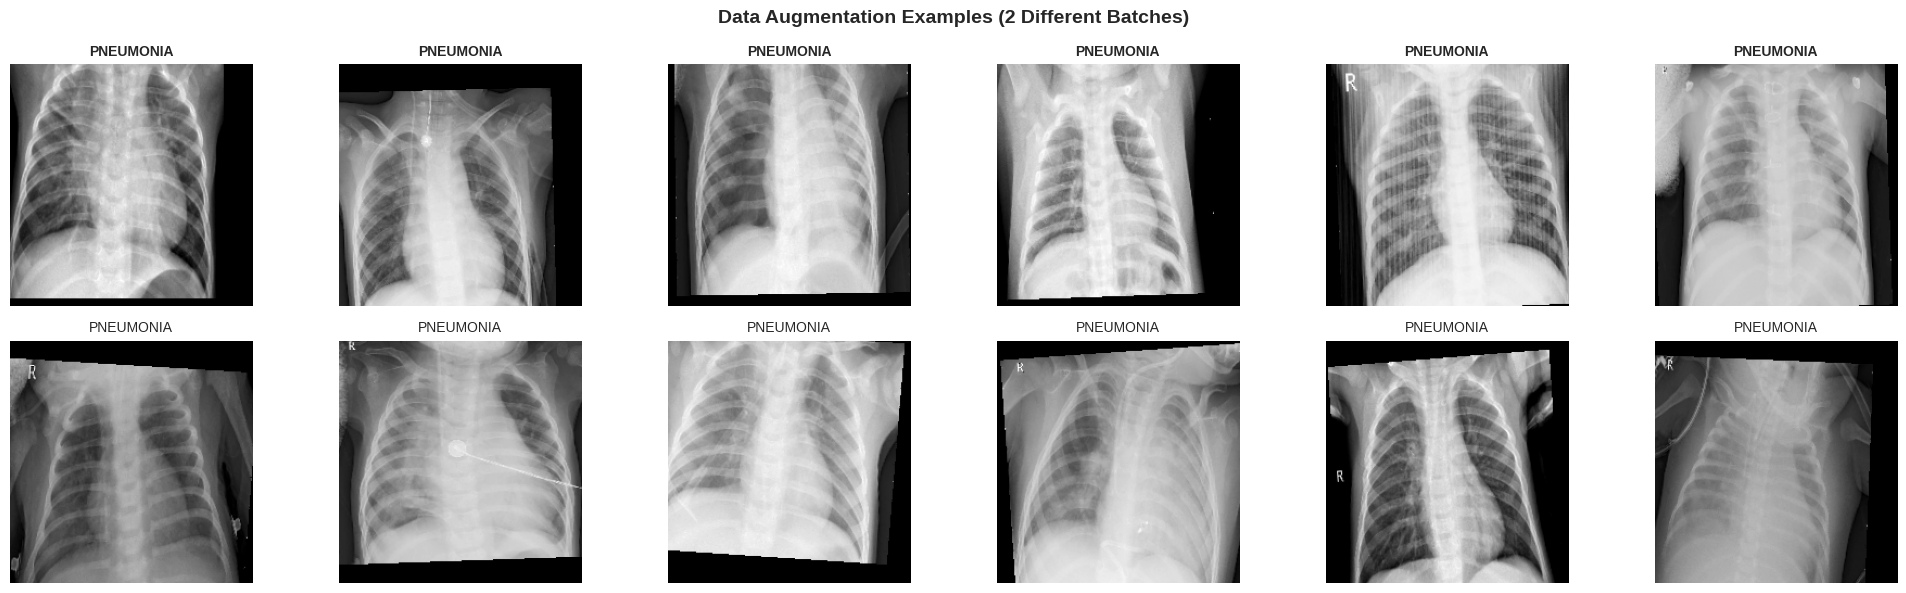

In [16]:
def visualize_augmentation(generator, num_images=6):
    """Display augmented versions of images"""
    batch_images, batch_labels = next(generator)
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    
    for i in range(min(num_images, len(batch_images))):
        axes[0, i].imshow(batch_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        label = "PNEUMONIA" if batch_labels[i] == 1 else "NORMAL"
        axes[0, i].set_title(f'{label}', fontsize=10, fontweight='bold')
    
    # Get another batch to show variation
    batch_images2, batch_labels2 = next(generator)
    for i in range(min(num_images, len(batch_images2))):
        axes[1, i].imshow(batch_images2[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        label = "PNEUMONIA" if batch_labels2[i] == 1 else "NORMAL"
        axes[1, i].set_title(f'{label}', fontsize=10)
    
    plt.suptitle('Data Augmentation Examples (2 Different Batches)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_augmentation(train_generator, num_images=6)
train_generator.reset()

In [17]:
def build_baseline_cnn(input_shape=(224, 224, 1)):
    """
    Baseline CNN for binary classification.
    Architecture: 4 Convolutional blocks with BatchNorm + GlobalAveragePooling + Dense layers
    """
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Global Average Pooling (reduces overfitting vs Flatten)
        GlobalAveragePooling2D(),
        
        # Dense layers with regularization
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ], name='Baseline_CNN')
    
    return model

print("=" * 60)
print("BASELINE CNN ARCHITECTURE")
print("=" * 60)

baseline_model = build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1))
baseline_model.summary()

print(f"\nTotal Parameters: {baseline_model.count_params():,}")

BASELINE CNN ARCHITECTURE


I0000 00:00:1767540648.815192      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,274,337 (4.86 MB)

 Trainable params: 1,272,417 (4.85 MB)

 Non-trainable params: 1,920 (7.50 KB)


Total Parameters: 1,274,337


In [18]:
EPOCHS_BASELINE = 20

# Callbacks
callbacks_baseline = [
    EarlyStopping(
        monitor='val_auc', 
        patience=8, 
        restore_best_weights=True, 
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=4, 
        min_lr=1e-7, 
        verbose=1
    ),
    ModelCheckpoint(
        'models/baseline_cnn_best.keras', 
        monitor='val_auc', 
        mode='max', 
        save_best_only=True, 
        verbose=1
    )
]

# Compile model
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("=" * 60)
print("TRAINING BASELINE CNN")
print("=" * 60)
print(f"Epochs: {EPOCHS_BASELINE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Initial learning rate: 0.0001\n")

# Reset generators before training
train_generator.reset()
val_generator.reset()

history_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_BASELINE,
    callbacks=callbacks_baseline,
    class_weight=class_weight_dict,
    verbose=1
)

# Report best results
best_epoch = np.argmax(history_baseline.history['val_auc']) + 1
best_val_auc = max(history_baseline.history['val_auc'])
print(f"\nBest Epoch: {best_epoch}")
print(f"Best val_auc: {best_val_auc:.4f}")

TRAINING BASELINE CNN
Epochs: 20
Batch size: 32
Initial learning rate: 0.0001

Epoch 1/20


I0000 00:00:1767540657.020108     121 service.cc:152] XLA service 0x78e79808da90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767540657.020149     121 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767540658.197699     121 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/147 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.7422 - auc: 0.5694 - loss: 1.0184 - precision: 0.8735 - recall: 0.8164 

I0000 00:00:1767540672.455628     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.7052 - auc: 0.7564 - loss: 1.0098 - precision: 0.8640 - recall: 0.7080
Epoch 1: val_auc improved from -inf to 0.50000, saving model to models/baseline_cnn_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 594ms/step - accuracy: 0.7056 - auc: 0.7570 - loss: 1.0090 - precision: 0.8644 - recall: 0.7083 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 1.8720 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8477 - auc: 0.9173 - loss: 0.7484 - precision: 0.9499 - recall: 0.8301
Epoch 2: val_auc did not improve from 0.50000
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 324ms/step - accuracy: 0.8477 - auc: 0.9173 - loss: 0.7482 - precision: 0.9499 - recall: 0.8302 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 3.1284 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0

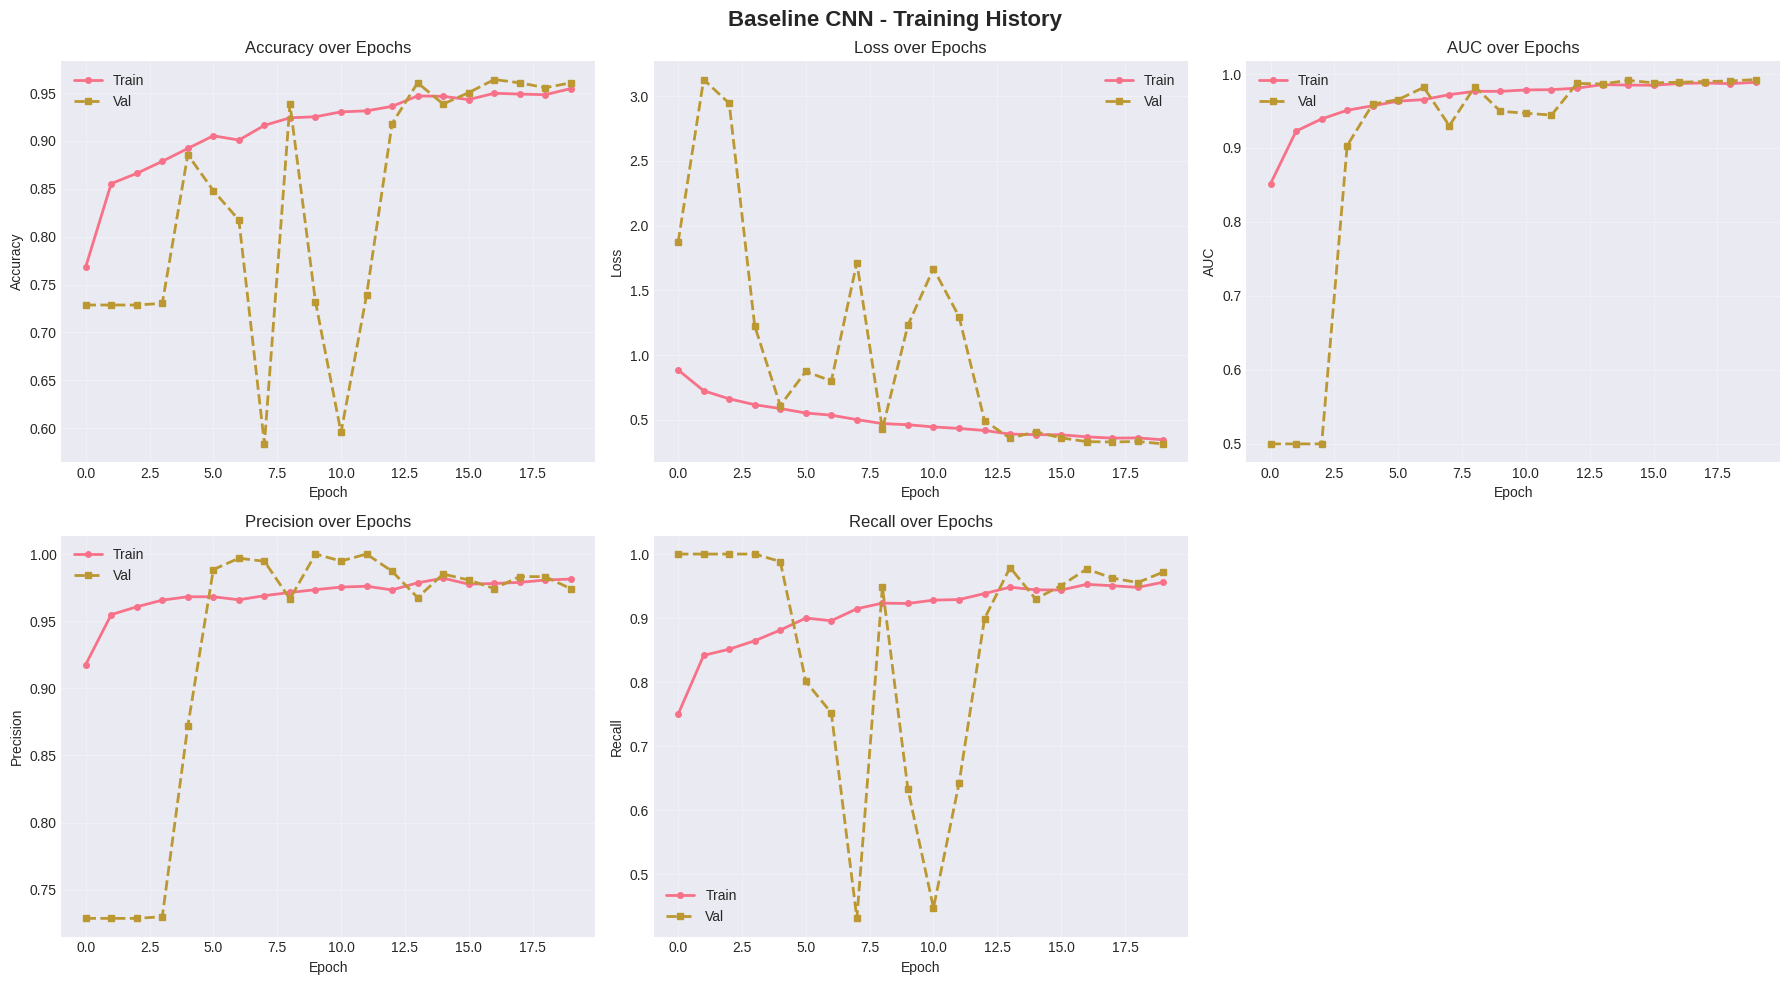

Loaded best baseline model from checkpoint
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.9603 - auc: 0.9789 - loss: 0.3524 - precision: 0.9753 - recall: 0.9703

Baseline CNN - Test Results:
  loss: 0.3765
  compile_metrics: 0.9539


In [19]:
def plot_training_history(history, model_name="Model"):
    """Plot training metrics over epochs"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = [
        ('accuracy', 'Accuracy'), 
        ('loss', 'Loss'), 
        ('auc', 'AUC'),
        ('precision', 'Precision'), 
        ('recall', 'Recall')
    ]
    
    for idx, (metric, title) in enumerate(metrics):
        row, col = idx // 3, idx % 3
        if metric in history.history:
            axes[row, col].plot(history.history[metric], label='Train', linewidth=2, marker='o', markersize=4)
            val_metric = f'val_{metric}'
            if val_metric in history.history:
                axes[row, col].plot(history.history[val_metric], label='Val', linewidth=2, 
                                    linestyle='--', marker='s', markersize=4)
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(title)
        axes[row, col].set_title(f'{title} over Epochs')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # Hide empty subplot
    axes[1, 2].axis('off')
    
    plt.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_training_history(history_baseline, "Baseline CNN")

# Load best model for evaluation
baseline_model = keras.models.load_model('models/baseline_cnn_best.keras')
print("Loaded best baseline model from checkpoint")

# Evaluate on test set
test_generator.reset()
test_results_baseline = baseline_model.evaluate(test_generator, verbose=1)

print("\nBaseline CNN - Test Results:")
for name, value in zip(baseline_model.metrics_names, test_results_baseline):
    print(f"  {name}: {value:.4f}")

In [20]:
print("=" * 60)
print("BUILDING RESNET50 TRANSFER LEARNING MODEL")
print("=" * 60)

# Clear memory from previous model
tf.keras.backend.clear_session()
gc.collect()

# Load pre-trained ResNet50 (without top classification layers)
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model initially
base_resnet.trainable = False

print(f"Loaded ResNet50 (frozen)")
print(f"  Total layers: {len(base_resnet.layers)}")

# Build model with grayscale-to-RGB conversion
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='grayscale_input')
x = layers.Concatenate()([inputs, inputs, inputs])  # Convert grayscale to 3-channel
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', name='output')(x)

resnet_model = Model(inputs=inputs, outputs=outputs, name='ResNet50_Pneumonia')

print("\nResNet50 Model Summary:")
resnet_model.summary()

# Compile for Phase 1 (frozen base)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("\nResNet50 compiled (base frozen, lr=0.001)")

BUILDING RESNET50 TRANSFER LEARNING MODEL
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded ResNet50 (frozen)
  Total layers: 175

ResNet50 Model Summary:


Model: "ResNet50_Pneumonia"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ grayscale_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ grayscale_input[… │
│ (Concatenate)       │ 3)                │            │ grayscale_input[… │
│                     │                   │            │ grayscale_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


ResNet50 compiled (base frozen, lr=0.001)


In [21]:
EPOCHS_RESNET_P1 = 10

resnet_callbacks = [
    EarlyStopping(
        monitor='val_auc', 
        patience=6, 
        restore_best_weights=True, 
        mode='max', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=1
    ),
    ModelCheckpoint(
        'models/resnet50_best.keras', 
        monitor='val_auc',
        mode='max', 
        save_best_only=True, 
        verbose=1
    )
]

print("=" * 60)
print("TRAINING RESNET50 - PHASE 1 (FROZEN BASE)")
print("=" * 60)
print("Training only custom classification layers")
print(f"Epochs: {EPOCHS_RESNET_P1}\n")

train_generator.reset()
val_generator.reset()

history_resnet_p1 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_RESNET_P1,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

best_auc_p1 = max(history_resnet_p1.history['val_auc'])
print(f"\nPhase 1 completed. Best val_auc: {best_auc_p1:.4f}")

TRAINING RESNET50 - PHASE 1 (FROZEN BASE)
Training only custom classification layers
Epochs: 10

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5179 - auc: 0.5177 - loss: 1.1273 - precision: 0.7389 - recall: 0.5282
Epoch 1: val_auc improved from -inf to 0.80865, saving model to models/resnet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 73s 405ms/step - accuracy: 0.5179 - auc: 0.5177 - loss: 1.1264 - precision: 0.7389 - recall: 0.5280 - val_accuracy: 0.7287 - val_auc: 0.8086 - val_loss: 0.8259 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.5240 - auc: 0.5204 - loss: 0.8681 - precision: 0.7484 - recall: 0.5299
Epoch 2: val_auc improved from 0.80865 to 0.86709, saving model to models/resnet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 323ms/step - accuracy: 0.5239 - auc: 0.5204 - loss: 0.8681 - precision: 0.7484 - recall: 0.5296 - val_accuracy: 0.8191 - val_auc: 0.8671 - val_loss: 

In [22]:
print("=" * 60)
print("TRAINING RESNET50 - PHASE 2 (FINE-TUNING)")
print("=" * 60)

# Unfreeze last 30 layers of base model for fine-tuning
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

trainable_layers = sum([1 for layer in base_resnet.layers if layer.trainable])
print(f"Unfroze last 30 layers ({trainable_layers} trainable)")

# Recompile with lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("Recompiled with lr=1e-5 for fine-tuning\n")

EPOCHS_RESNET_P2 = 10

train_generator.reset()
val_generator.reset()

history_resnet_p2 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_RESNET_P2,
    callbacks=resnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

best_auc_p2 = max(history_resnet_p2.history['val_auc'])
print(f"\nPhase 2 completed. Best val_auc: {best_auc_p2:.4f}")

TRAINING RESNET50 - PHASE 2 (FINE-TUNING)
Unfroze last 30 layers (30 trainable)
Recompiled with lr=1e-5 for fine-tuning

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6156 - auc: 0.7982 - loss: 0.6287 - precision: 0.8983 - recall: 0.5155
Epoch 1: val_auc improved from 0.87845 to 0.93334, saving model to models/resnet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.6165 - auc: 0.7987 - loss: 0.6281 - precision: 0.8986 - recall: 0.5168 - val_accuracy: 0.2713 - val_auc: 0.9333 - val_loss: 0.9903 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8681 - auc: 0.9311 - loss: 0.3939 - precision: 0.9464 - recall: 0.8699
Epoch 2: val_auc improved from 0.93334 to 0.97988, saving model to models/resnet50_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 326ms/step - accuracy: 0.8681 - auc: 0.9312 - loss: 0.3938 - precision: 0.9464 - recall: 0.8699 - val_accuracy

RESNET50 - TEST SET EVALUATION
Loaded best ResNet50 model from checkpoint
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9202 - auc: 0.9889 - loss: 0.2125 - precision: 0.9884 - recall: 0.9013

ResNet50 - Test Results:
  loss: 0.2162
  compile_metrics: 0.9232


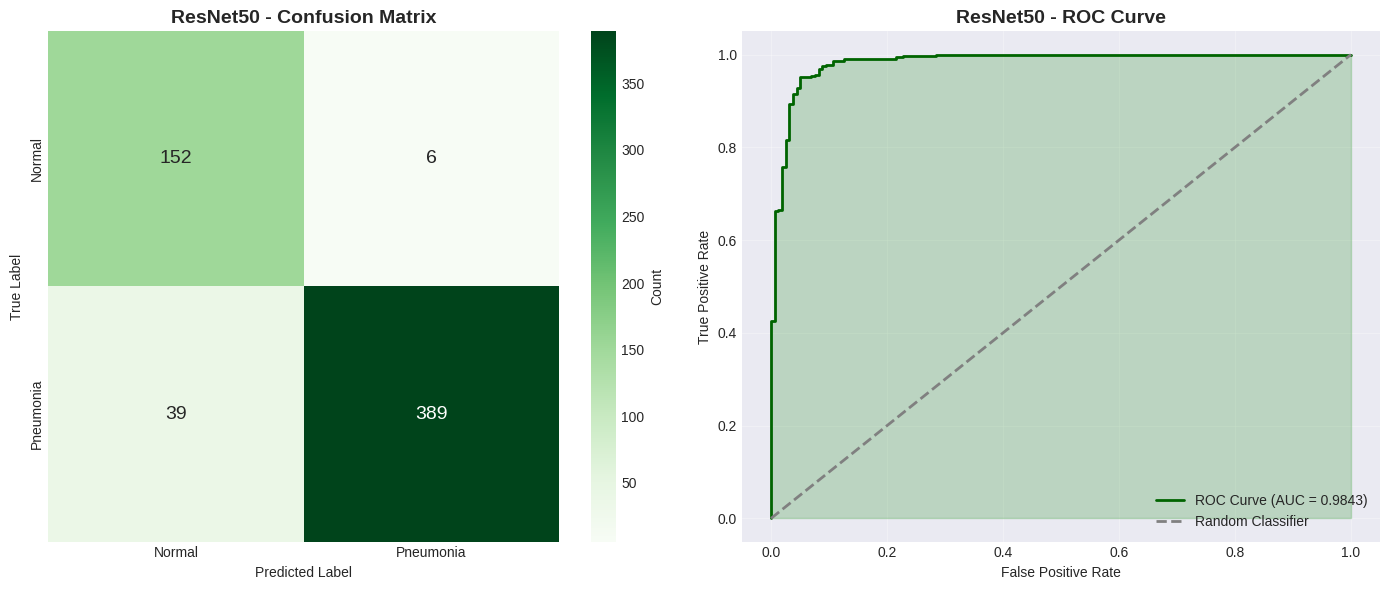


Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      0.96      0.87       158
   Pneumonia       0.98      0.91      0.95       428

    accuracy                           0.92       586
   macro avg       0.89      0.94      0.91       586
weighted avg       0.93      0.92      0.93       586



In [23]:
print("=" * 60)
print("RESNET50 - TEST SET EVALUATION")
print("=" * 60)

# Load best model
resnet_model = keras.models.load_model('models/resnet50_best.keras')
print("Loaded best ResNet50 model from checkpoint")

# Evaluate on test set
test_generator.reset()
test_results_resnet = resnet_model.evaluate(test_generator, verbose=1)

print("\nResNet50 - Test Results:")
for name, value in zip(resnet_model.metrics_names, test_results_resnet):
    print(f"  {name}: {value:.4f}")

# Get predictions for detailed analysis
test_generator.reset()
resnet_pred_proba = resnet_model.predict(test_generator, verbose=0)
resnet_pred = (resnet_pred_proba > 0.5).astype(int).flatten()
y_true_resnet = test_generator.classes

# Confusion Matrix and ROC Curve
cm_resnet = confusion_matrix(y_true_resnet, resnet_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            ax=axes[0], cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
axes[0].set_title('ResNet50 - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_resnet, resnet_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.2, color='green')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ResNet50 - ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/resnet50_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_resnet, resnet_pred, target_names=['Normal', 'Pneumonia']))

In [24]:
print("=" * 60)
print("BUILDING EFFICIENTNETB0 MODEL")
print("=" * 60)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

# Load pre-trained EfficientNetB0
base_effnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model initially
base_effnet.trainable = False

print(f"Loaded EfficientNetB0 (frozen)")
print(f"  Total layers: {len(base_effnet.layers)}")

# Build model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='grayscale_input')
x = layers.Concatenate()([inputs, inputs, inputs])  # Grayscale to 3-channel
x = base_effnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid', name='output')(x)

effnet_model = Model(inputs=inputs, outputs=outputs, name='EfficientNetB0_Pneumonia')

# Compile
effnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("\nEfficientNetB0 compiled (base frozen, lr=0.001)")

BUILDING EFFICIENTNETB0 MODEL
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded EfficientNetB0 (frozen)
  Total layers: 238

EfficientNetB0 compiled (base frozen, lr=0.001)


In [25]:
EPOCHS_EFFNET = 15

effnet_callbacks = [
    EarlyStopping(
        monitor='val_auc', 
        patience=6, 
        restore_best_weights=True, 
        mode='max', 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=1
    ),
    ModelCheckpoint(
        'models/efficientnet_best.keras', 
        monitor='val_auc',
        mode='max', 
        save_best_only=True, 
        verbose=1
    )
]

print("=" * 60)
print("TRAINING EFFICIENTNETB0")
print("=" * 60)
print(f"Epochs: {EPOCHS_EFFNET}\n")

# Reset generators
train_generator.reset()
val_generator.reset()

history_effnet = effnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_EFFNET,
    callbacks=effnet_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

best_auc_effnet = max(history_effnet.history['val_auc'])
print(f"\nTraining completed. Best val_auc: {best_auc_effnet:.4f}")

TRAINING EFFICIENTNETB0
Epochs: 15

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5507 - auc: 0.5185 - loss: 1.2115 - precision: 0.7438 - recall: 0.5883
Epoch 1: val_auc improved from -inf to 0.50000, saving model to models/efficientnet_best.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 497ms/step - accuracy: 0.5504 - auc: 0.5184 - loss: 1.2109 - precision: 0.7437 - recall: 0.5879 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 0.9541 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5046 - auc: 0.5102 - loss: 0.9251 - precision: 0.7322 - recall: 0.5020
Epoch 2: val_auc did not improve from 0.50000
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 313ms/step - accuracy: 0.5046 - auc: 0.5102 - loss: 0.9249 - precision: 0.7322 - recall: 0.5020 - val_accuracy: 0.7287 - val_auc: 0.5000 - val_loss: 0.8248 - val_precision: 0.7287 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
147/147 ━━━━━━━━━━

MODEL COMPARISON - TEST SET EVALUATION

Baseline CNN:
  accuracy: 0.9539
  precision: 0.9652
  recall: 0.9720
  f1: 0.9686
  auc: 0.9822

ResNet50:
  accuracy: 0.9232
  precision: 0.9848
  recall: 0.9089
  f1: 0.9453
  auc: 0.9843

EfficientNetB0:
  accuracy: 0.7304
  precision: 0.7304
  recall: 1.0000
  f1: 0.8442
  auc: 0.6346


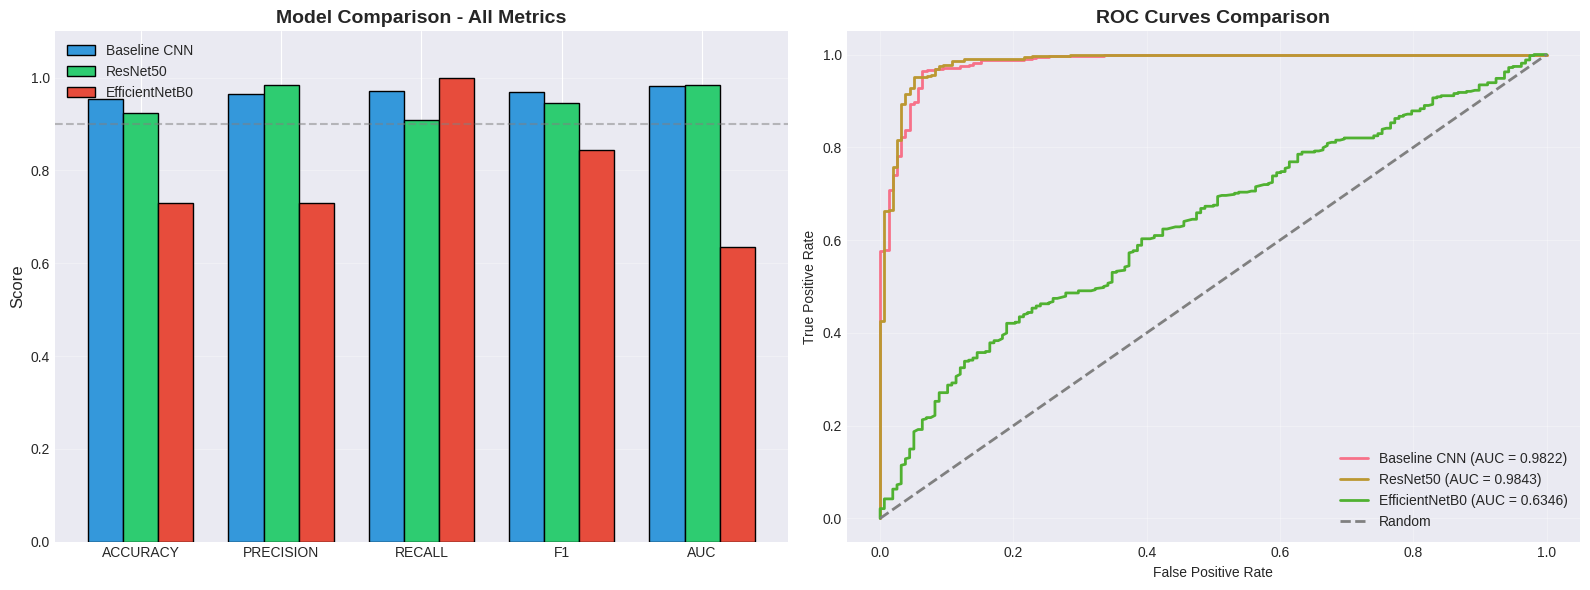


Best Model by AUC: ResNet50 (AUC = 0.9843)


In [26]:
print("=" * 60)
print("MODEL COMPARISON - TEST SET EVALUATION")
print("=" * 60)

# Load all best models
baseline_model = keras.models.load_model('models/baseline_cnn_best.keras')
resnet_model = keras.models.load_model('models/resnet50_best.keras')
effnet_model = keras.models.load_model('models/efficientnet_best.keras')

# Evaluate all models on test set
models_dict = {
    'Baseline CNN': baseline_model,
    'ResNet50': resnet_model,
    'EfficientNetB0': effnet_model
}

results = {}
predictions = {}

for name, model in models_dict.items():
    test_generator.reset()
    eval_results = model.evaluate(test_generator, verbose=0)
    
    # Get predictions
    test_generator.reset()
    pred_proba = model.predict(test_generator, verbose=0)
    pred = (pred_proba > 0.5).astype(int).flatten()
    y_true = test_generator.classes
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_true, pred),
        'precision': precision_score(y_true, pred),
        'recall': recall_score(y_true, pred),
        'f1': f1_score(y_true, pred),
        'auc': roc_auc_score(y_true, pred_proba)
    }
    predictions[name] = {'proba': pred_proba, 'pred': pred}
    
    print(f"\n{name}:")
    for metric, value in results[name].items():
        print(f"  {metric}: {value:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
x = np.arange(len(metrics_to_plot))
width = 0.25

colors = ['#3498db', '#2ecc71', '#e74c3c']
for i, (name, res) in enumerate(results.items()):
    values = [res[m] for m in metrics_to_plot]
    bars = axes[0].bar(x + i*width, values, width, label=name, color=colors[i], edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels([m.upper() for m in metrics_to_plot])
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
y_true = test_generator.classes
for name, pred_data in predictions.items():
    fpr, tpr, _ = roc_curve(y_true, pred_data['proba'])
    auc_score = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.4f})')

axes[1].plot([0, 1], [0, 1], 'gray', lw=2, linestyle='--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine best model
best_model_name = max(results, key=lambda k: results[k]['auc'])
print(f"\nBest Model by AUC: {best_model_name} (AUC = {results[best_model_name]['auc']:.4f})")

In [27]:
print("=" * 60)
print("FINAL EVALUATION - BEST MODEL")
print("=" * 60)

# Load best model based on AUC comparison
best_model = keras.models.load_model(f'models/{best_model_name.lower().replace(" ", "_")}_best.keras')
print(f"Best Model: {best_model_name}")

# Get predictions
test_generator.reset()
y_pred_proba = best_model.predict(test_generator, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Calculate detailed metrics
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred_proba)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

print("\nTEST SET PERFORMANCE:")
print(f"  Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision:   {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:      {recall:.4f} ({recall*100:.2f}%) [Sensitivity]")
print(f"  Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"  F1-Score:    {f1:.4f}")
print(f"  AUC-ROC:     {auc_score:.4f}")
print(f"  NPV:         {npv:.4f}")

print(f"\nCONFUSION MATRIX:")
print(f"                    Predicted")
print(f"                Normal  Pneumonia")
print(f"Actual Normal     {tn:4d}      {fp:4d}")
print(f"       Pneumonia  {fn:4d}      {tp:4d}")

print(f"\nCLINICAL INTERPRETATION:")
print(f"  - True Positives:  {tp} pneumonia cases correctly detected")
print(f"  - True Negatives:  {tn} normal cases correctly identified")
print(f"  - False Negatives: {fn} missed pneumonia cases (critical in medical context)")
print(f"  - False Positives: {fp} false alarms")

# Save training histories
history_dict = {
    'baseline': history_baseline.history,
    'resnet_phase1': history_resnet_p1.history,
    'resnet_phase2': history_resnet_p2.history,
    'efficientnet': history_effnet.history
}

with open('models/training_history.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

# Save results summary
results_summary = {
    'models_comparison': {k: {m: float(v) for m, v in res.items()} for k, res in results.items()},
    'best_model': best_model_name,
    'test_metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'specificity': float(specificity),
        'f1_score': float(f1),
        'auc': float(auc_score),
        'npv': float(npv)
    },
    'confusion_matrix': cm.tolist()
}

with open('models/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "=" * 60)
print("PROJECT COMPLETE")
print("=" * 60)
print("""
Completed Tasks:
  - Dataset analysis and visualization
  - Stratified train/val/test split (80/10/10)
  - Data augmentation pipeline (medical-appropriate)
  - Baseline CNN from scratch
  - ResNet50 transfer learning (2-phase training)
  - EfficientNetB0 transfer learning
  - Comprehensive model comparison
  - Clinical metrics calculation

Saved Files:
  - models/baseline_cnn_best.keras
  - models/resnet50_best.keras
  - models/efficientnet_best.keras
  - models/training_history.pkl
  - models/results_summary.json
  - models/*.png (visualizations)

Next Steps:
  - Deploy model via Streamlit/Gradio app
  - Add Grad-CAM visualization for interpretability
  - Validate on external datasets
  - Clinical validation with domain experts
""")

FINAL EVALUATION - BEST MODEL
Best Model: ResNet50

TEST SET PERFORMANCE:
  Accuracy:    0.9232 (92.32%)
  Precision:   0.9848 (98.48%)
  Recall:      0.9089 (90.89%) [Sensitivity]
  Specificity: 0.9620 (96.20%)
  F1-Score:    0.9453
  AUC-ROC:     0.9843
  NPV:         0.7958

CONFUSION MATRIX:
                    Predicted
                Normal  Pneumonia
Actual Normal      152         6
       Pneumonia    39       389

CLINICAL INTERPRETATION:
  - True Positives:  389 pneumonia cases correctly detected
  - True Negatives:  152 normal cases correctly identified
  - False Negatives: 39 missed pneumonia cases (critical in medical context)
  - False Positives: 6 false alarms

PROJECT COMPLETE

Completed Tasks:
  - Dataset analysis and visualization
  - Stratified train/val/test split (80/10/10)
  - Data augmentation pipeline (medical-appropriate)
  - Baseline CNN from scratch
  - ResNet50 transfer learning (2-phase training)
  - EfficientNetB0 transfer learning
  - Comprehensive model